In [50]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

#Ideas from below for suppressing errors in lasso and elasticnet models
#https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [51]:
# Read the data
ames = pd.read_csv("AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

## Bad overfit model

In [52]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2') #Math breaks when number of predictors is large relative to # of samples

array([-1.14278700e+17, -2.87113132e+18, -1.04534436e+18, -5.69265871e+19,
       -4.96936722e+18])

## Ridge Regression lambda=1 model

In [53]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), #Need to standardize here to prevent human units from changing coefficient interpretation
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge", Ridge(alpha=1))]
)
cross_val_score(lr_pipeline_2, X, y, cv = 5, scoring = 'r2') #Math breaks when number of predictors is large relative to # of samples

array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

## Comparing model coefficients

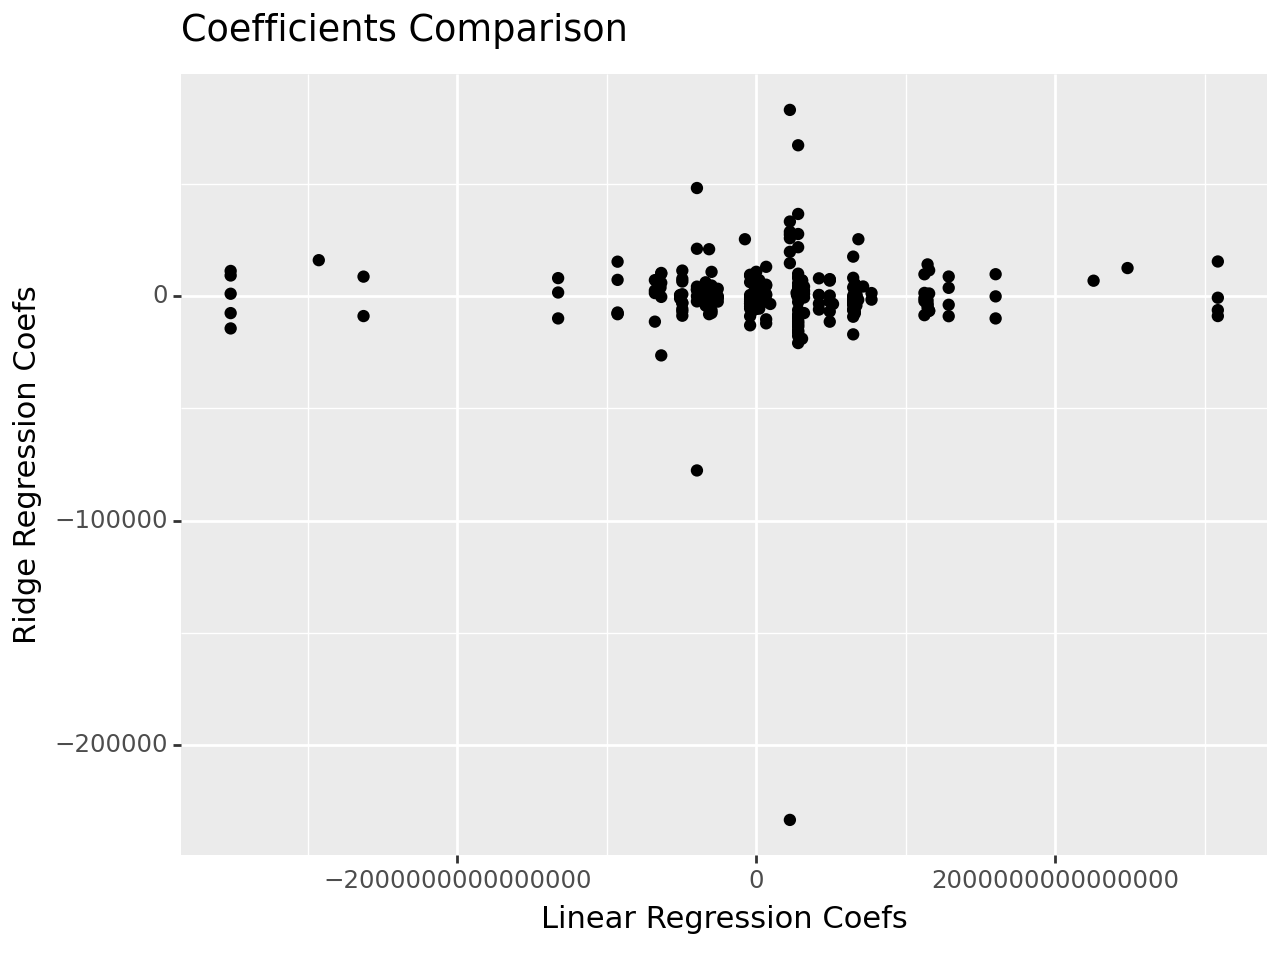

<Figure Size: (640 x 480)>

In [54]:
#Fit the model and predict values
lr_pipeline_1.fit(X, y)
y_pred1 = lr_pipeline_1.predict(X)
coefs1 = list(lr_pipeline_1.named_steps['linear_regression'].coef_)

lr_pipeline_2.fit(X, y)
y_pred2 = lr_pipeline_2.predict(X)
coefs2 = list(lr_pipeline_2.named_steps['ridge'].coef_)

(ggplot(pd.DataFrame(data={"Linear":coefs1,"Ridge":coefs2}), aes(x='Linear', y='Ridge'))
    + labs(x='Linear Regression Coefs', y='Ridge Regression Coefs', title='Coefficients Comparison')
    + geom_point()
    )

## Tuning to different lambda values

In [55]:

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

for lambda_ in [0.001,0.01,0.1,1,10,100]:
    lr_pipeline_3 = Pipeline(
      [("preprocessing", ct),
      ("ridge", Ridge(alpha=lambda_))]
    )
    print("Lambda of {}".format(lambda_))
    cvals = cross_val_score(lr_pipeline_3, X, y, cv = 5, scoring = 'r2')
    
    print(cvals.mean()) #Math breaks when number of predictors is large relative to # of samples

Lambda of 0.001
0.8529454580764166
Lambda of 0.01
0.8532236194833451
Lambda of 0.1
0.8554231896664213
Lambda of 1
0.8611593144036662
Lambda of 10
0.8633548524419268
Lambda of 100
0.8571291093859319


## Lasso Pipeline

In [33]:
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

for lambda_ in [0.001,0.01,0.1,1,10,100,1000]:
    lasso_pipe = Pipeline(
      [("preprocessing", ct),
      ("regression", Lasso(alpha=lambda_,max_iter = 1000))]
    )
    print("Lambda of {}".format(lambda_))
    cvals = cross_val_score(lasso_pipe, X, y, cv = 5, scoring = 'r2')
    
    print(cvals.mean()) #Math breaks when number of predictors is large relative to # of samples

Lambda of 0.001


C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+11, tolerance: 1.348e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 1.474e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+11, tolerance: 1.463e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

0.8544397995269115
Lambda of 0.01


C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e+11, tolerance: 1.348e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+11, tolerance: 1.474e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e+11, tolerance: 1.463e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

0.854549158954238
Lambda of 0.1


C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+11, tolerance: 1.348e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+11, tolerance: 1.474e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+11, tolerance: 1.463e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

0.8553942923313158
Lambda of 1


C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+10, tolerance: 1.474e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e+10, tolerance: 1.463e+09
C:\Users\TobyG\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+10, tolerance: 1.477e+09


0.855890065025586
Lambda of 10
0.8594950842585083
Lambda of 100
0.866170225869277
Lambda of 1000
0.839605512352312


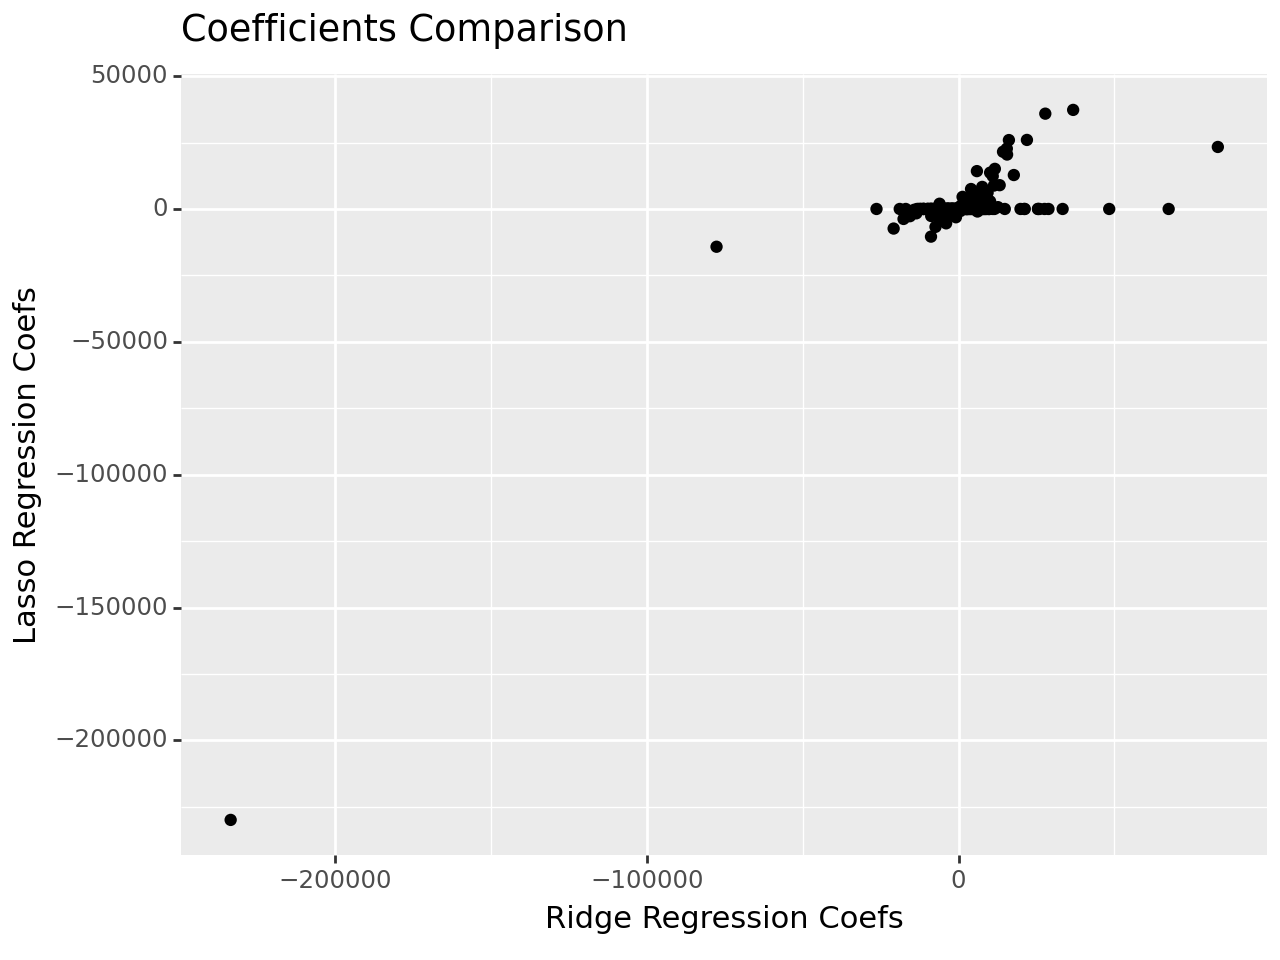

<Figure Size: (640 x 480)>

In [56]:
#Fit the model and predict values
lasso_pipe = Pipeline(
      [("preprocessing", ct),
      ("regression", Lasso(alpha=100,max_iter = 1000))]
    )
lasso_pipe.fit(X, y)
y_pred_lasso = lasso_pipe.predict(X)
coefs_lasso = list(lasso_pipe.named_steps['regression'].coef_)

(ggplot(pd.DataFrame(data={"Linear":coefs1,"Ridge":coefs2,"Lasso":coefs_lasso}), aes(x='Ridge', y='Lasso'))
    + labs(x='Ridge Regression Coefs', y='Lasso Regression Coefs', title='Coefficients Comparison')
    + geom_point()
    )

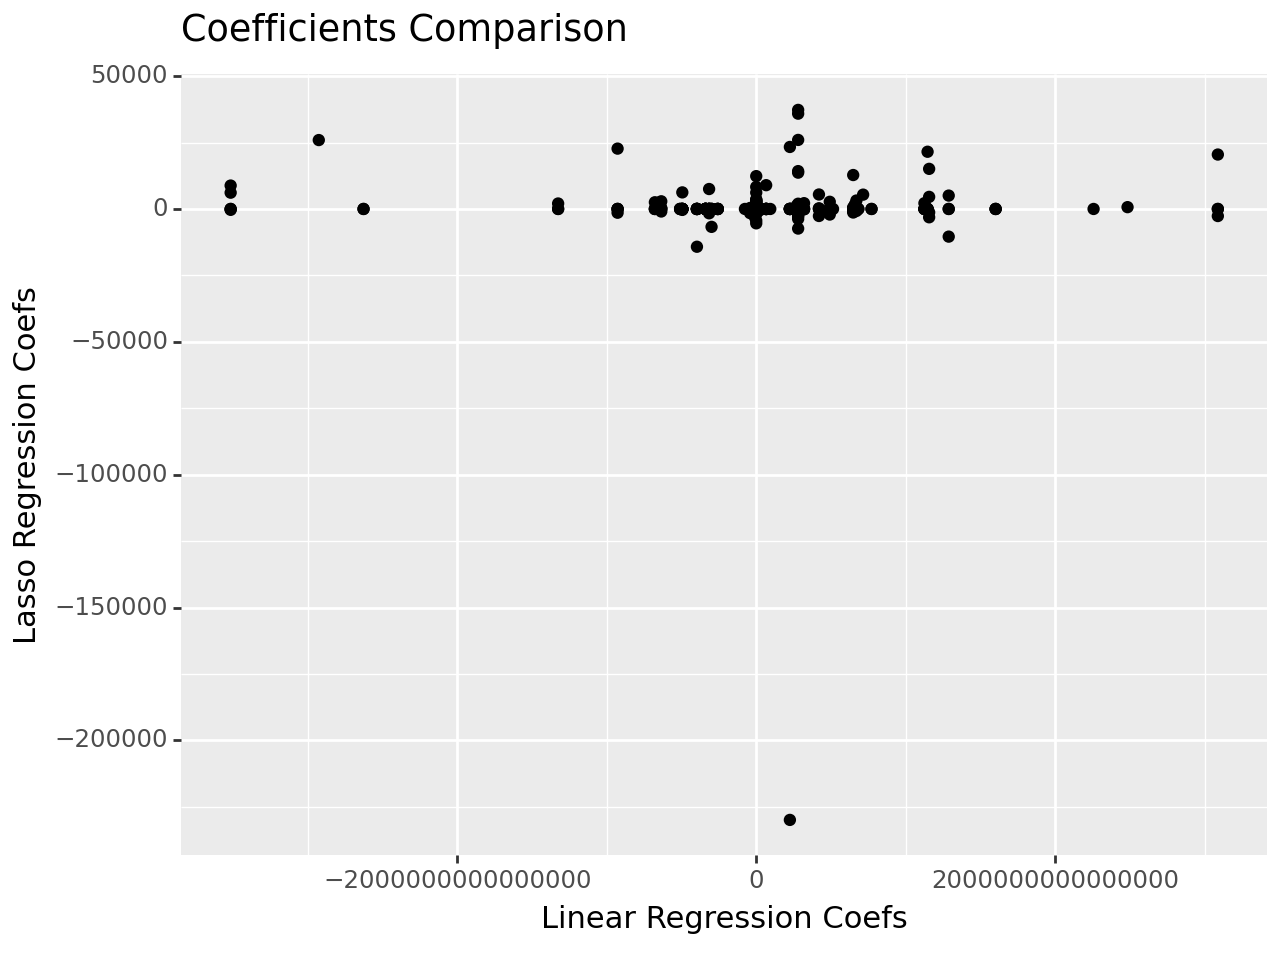

<Figure Size: (640 x 480)>

In [57]:
(ggplot(pd.DataFrame(data={"Linear":coefs1,"Ridge":coefs2,"Lasso":coefs_lasso}), aes(x='Linear', y='Lasso'))
    + labs(x='Linear Regression Coefs', y='Lasso Regression Coefs', title='Coefficients Comparison')
    + geom_point()
    )

In [58]:
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

best = {"lambda":0,"ratio":0}
best_cval = 0
for lambda_ in [0.001,0.01,0.1,1,10,100,1000]:
    for ratio in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
        elastic_pipe = Pipeline(
          [("preprocessing", ct),
          ("regression", ElasticNet(alpha=lambda_,l1_ratio=ratio,max_iter = 1000))]
        )
        cvals = cross_val_score(elastic_pipe, X, y, cv = 5, scoring = 'r2')
        print(lambda_,ratio,cvals.mean())
        if cvals.mean() > best_cval:
            best_cval = cvals.mean()
            best["lambda"] = lambda_
            best["ratio"] = ratio
best

0.001 0 0.8623896197407237
0.001 0.1 0.8622639708214237
0.001 0.2 0.862113000001439
0.001 0.3 0.8619271839176121
0.001 0.4 0.8616914557879785
0.001 0.5 0.8613806869559927
0.001 0.6 0.8609500631426183
0.001 0.7 0.8603124476716297
0.001 0.8 0.8592774522905511
0.001 0.9 0.8573552519450006
0.001 1 0.8544397995269115
0.01 0 0.8627437898826804
0.01 0.1 0.8629031306340172
0.01 0.2 0.8630493742871719
0.01 0.3 0.8631771273708401
0.01 0.4 0.8632786333452508
0.01 0.5 0.863342401310479
0.01 0.6 0.863350206581815
0.01 0.7 0.863270490909142
0.01 0.8 0.8630351084792294
0.01 0.9 0.8623914920036896
0.01 1 0.854549158954238
0.1 0 0.8513238785971338
0.1 0.1 0.852188558499626
0.1 0.2 0.8531129449881375
0.1 0.3 0.8541094510040225
0.1 0.4 0.8551942816815329
0.1 0.5 0.8563889762359503
0.1 0.6 0.8577219024627558
0.1 0.7 0.8592286681483978
0.1 0.8 0.8609392890948252
0.1 0.9 0.8627452619329926
0.1 1 0.8553942923313158
1 0 0.8118446548770306
1 0.1 0.8154555502063175
1 0.2 0.8191120052965944
1 0.3 0.8228347348835

{'lambda': 100, 'ratio': 1}

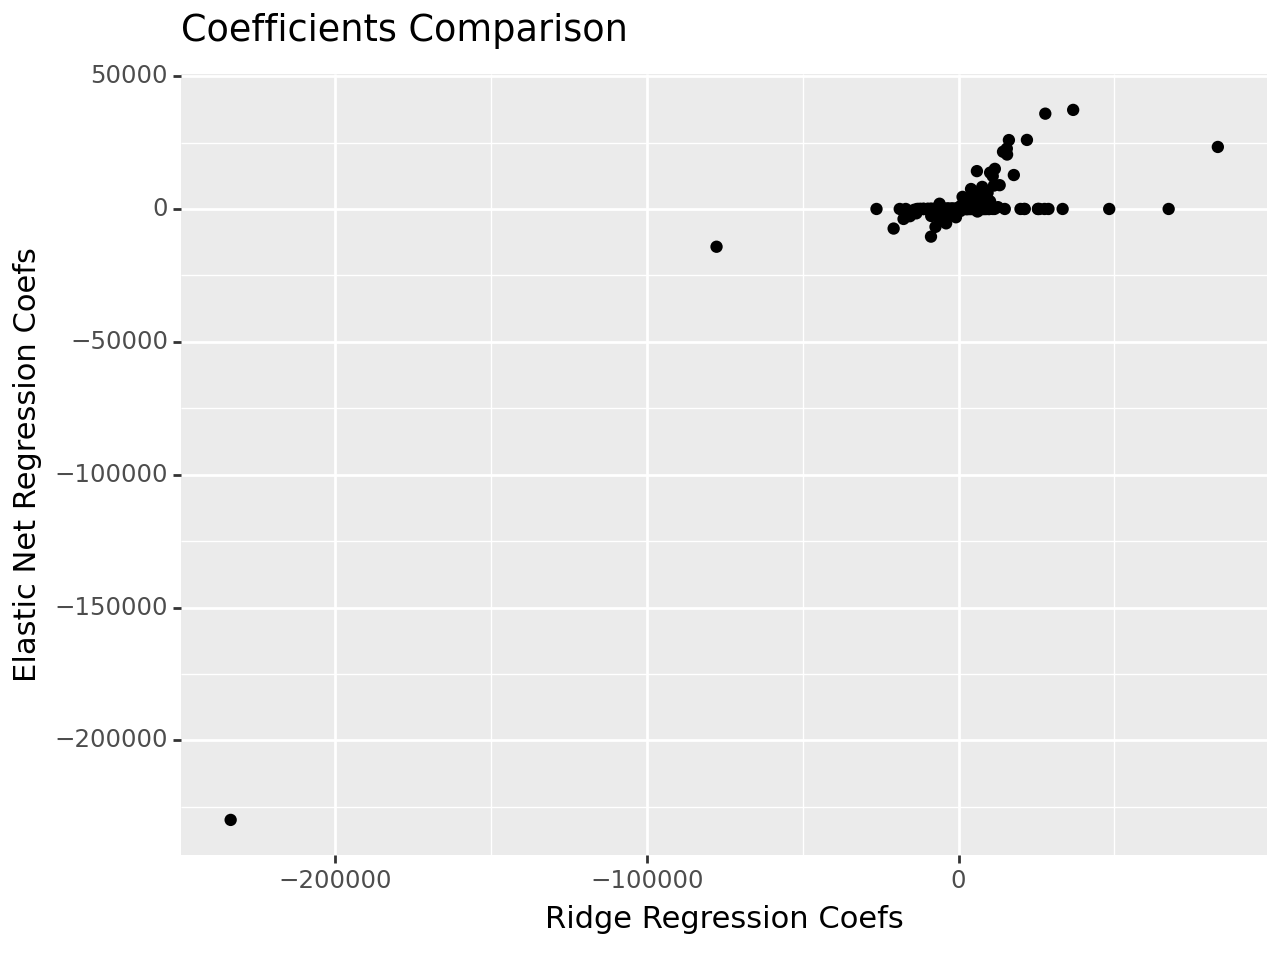

<Figure Size: (640 x 480)>

In [61]:
#Fit the model and predict values
elastic_pipe = Pipeline(
      [("preprocessing", ct),
      ("regression", ElasticNet(alpha=best["lambda"],l1_ratio=best["ratio"],max_iter = 1000))]
    )
elastic_pipe.fit(X, y)
y_pred_elastic = elastic_pipe.predict(X)
coefs_elastic = list(elastic_pipe.named_steps['regression'].coef_)

(ggplot(pd.DataFrame(data={"Linear":coefs1,"Ridge":coefs2,"Elastic Net":coefs_elastic}), aes(x='Ridge', y='Elastic Net'))
    + labs(x='Ridge Regression Coefs', y='Elastic Net Regression Coefs', title='Coefficients Comparison')
    + geom_point()
    )

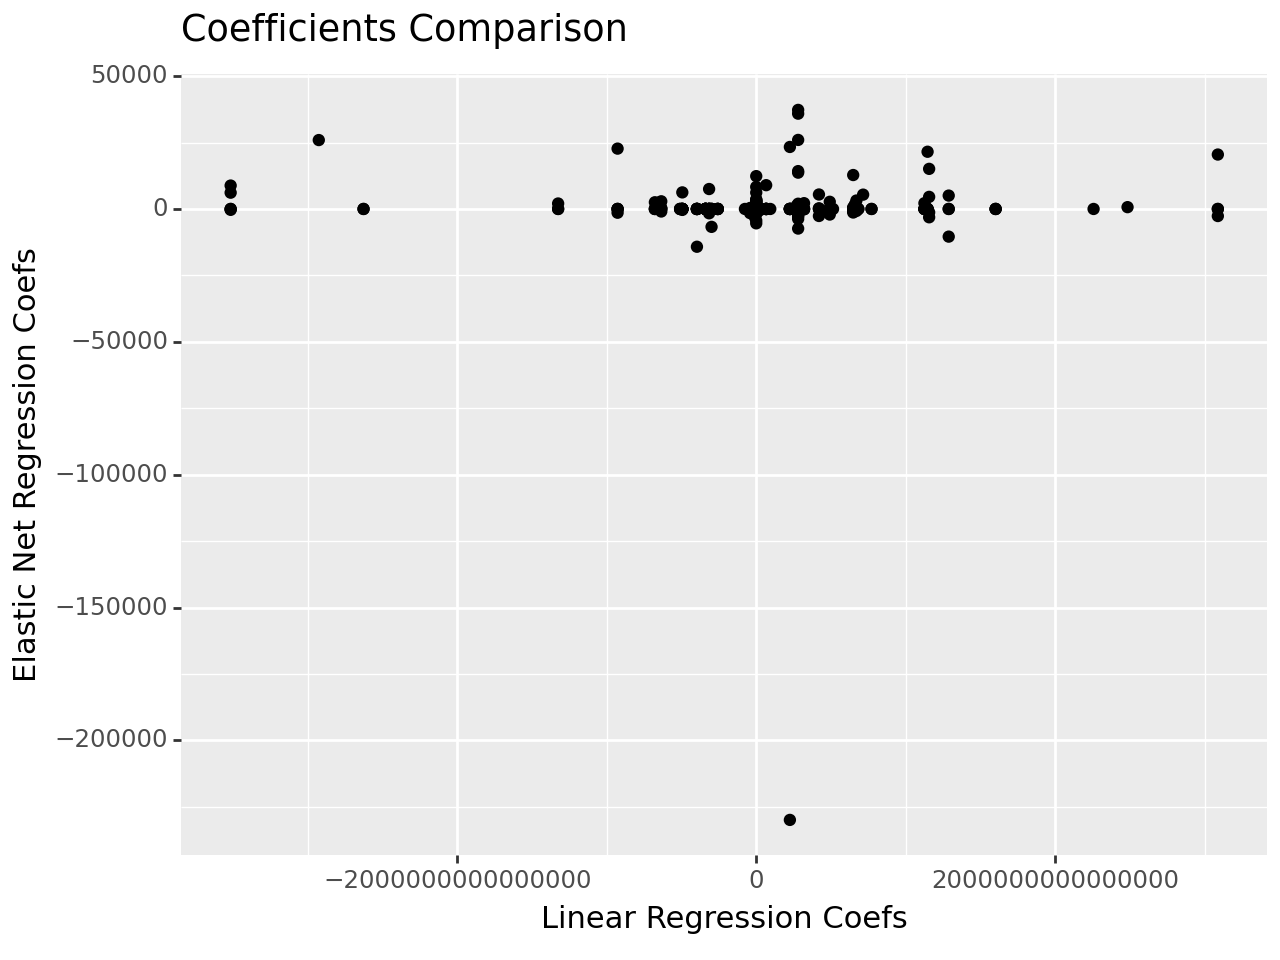

<Figure Size: (640 x 480)>

In [62]:
(ggplot(pd.DataFrame(data={"Linear":coefs1,"Ridge":coefs2,"Elastic Net":coefs_elastic}), aes(x='Linear', y='Elastic Net'))
    + labs(x='Linear Regression Coefs', y='Elastic Net Regression Coefs', title='Coefficients Comparison')
    + geom_point()
    )